<a href="https://colab.research.google.com/github/peterbabulik/QSPC/blob/main/QSPC_on_Real_IBM_Quantum_Hardware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Quantum Engines...
✅ Environment Ready.

🚀 STEP 1: Training Z-Boson Model (Digital Twin)...
✅ Model Trained on Simulator.

🔄 STEP 2: Converting Circuit to Qiskit...
   - Circuit Transpilation Successful.

🔌 STEP 3: Connecting to IBM Quantum Service...


/usr/local/lib/python3.12/dist-packages/pennylane/tape/qscript.py:1179: PennyLaneDeprecationWarning: ``QuantumScript.to_openqasm`` is deprecated and will be removed in v0.44. Instead, please use ``qml.to_openqasm``.
  warnings.warn(
qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-28 15:21:34,812: Default instance not set. Searching all available instances.


   - 🎯 TARGETING HARDWARE: ibm_fez...
   - Error finding ibm_fez: 'BackendStatus' object has no attribute 'state'
   - Switching to 'least_busy'...
   - Found: ibm_fez
   - Optimizing circuit for ibm_fez...
   - 🚀 SUBMITTING JOB TO IBM_FEZ...
   - Job ID: d4krs143tdfc73dor1f0
   - Waiting for results (Real hardware queue)...
✅ Results Received.


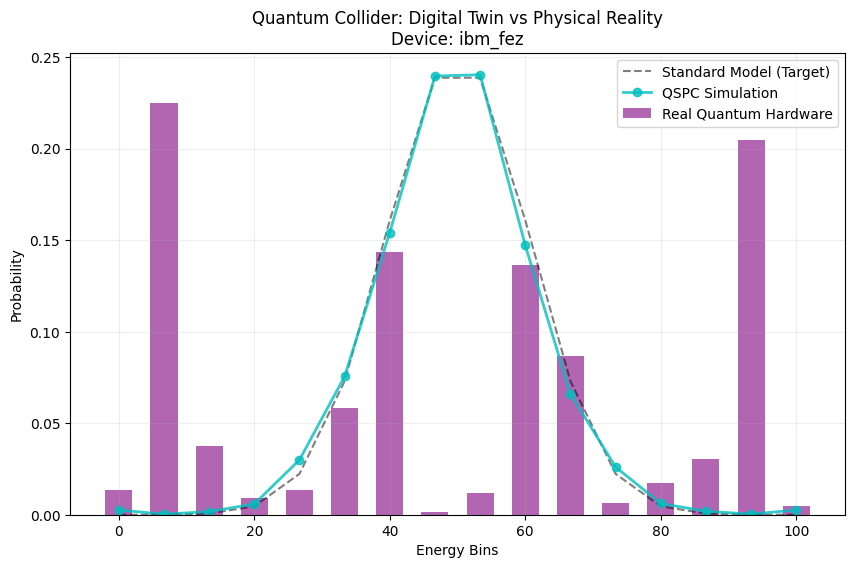

In [5]:
import subprocess
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. INSTALL DEPENDENCIES
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("Installing Quantum Engines...")
try:
    import pennylane as qml
    import qiskit
    from qiskit import QuantumCircuit
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
except ImportError:
    install("pennylane")
    install("qiskit")
    install("qiskit-ibm-runtime")
    import pennylane as qml
    import qiskit
    from qiskit import QuantumCircuit
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

print("✅ Environment Ready.")

# ==========================================
# STEP 1: TRAIN THE PHYSICS (PennyLane Simulator)
# ==========================================
print("\n🚀 STEP 1: Training Z-Boson Model (Digital Twin)...")

n_qubits = 4
dev_sim = qml.device("default.qubit", wires=n_qubits)

# Target Physics (Z-Boson Peak)
bins = 2**n_qubits
x_axis = np.linspace(0, 100, bins)
target_dist = np.exp(-(x_axis - 50)**2 / (15)**2)
target_dist = target_dist / np.sum(target_dist)
target_tensor = torch.tensor(target_dist, dtype=torch.float32)

@qml.qnode(dev_sim, interface="torch")
def generator_circuit(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

# Optimization
weights = torch.randn(2, n_qubits, 3, requires_grad=True)
opt = torch.optim.Adam([weights], lr=0.1)

for i in range(51):
    opt.zero_grad()
    probs = generator_circuit(weights)
    loss = torch.sum((probs - target_tensor)**2)
    loss.backward()
    opt.step()

print("✅ Model Trained on Simulator.")

# ==========================================
# STEP 2: CONVERT TO QISKIT
# ==========================================
print("\n🔄 STEP 2: Converting Circuit to Qiskit...")

final_weights = weights.detach().numpy()

@qml.qnode(dev_sim)
def export_layer(w):
    qml.StronglyEntanglingLayers(w, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

# Generate QASM String
# We use the tape method which worked previously
tape = qml.workflow.construct_tape(export_layer)(final_weights)
try:
    qasm_str = tape.to_openqasm()
except:
    # Fallback for different PennyLane versions
    qasm_str = qml.to_openqasm(tape)

# Reconstruct in Qiskit
qc = QuantumCircuit.from_qasm_str(qasm_str)
qc.measure_all()
print("   - Circuit Transpilation Successful.")

# ==========================================
# STEP 3: EXECUTE ON IBM_FEZ
# ==========================================
print("\n🔌 STEP 3: Connecting to IBM Quantum Service...")

IBM_TOKEN = "api key here"

# Initialize Service with the platform channel required by your version
try:
    service = QiskitRuntimeService(channel="ibm_quantum", token=IBM_TOKEN)
except:
    # Explicit fallback for strict versions
    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=IBM_TOKEN)

# HARD TARGET: IBM FEZ
target_backend_name = "ibm_fez"
print(f"   - 🎯 TARGETING HARDWARE: {target_backend_name}...")

try:
    backend = service.backend(target_backend_name)
    print(f"   - Status: {backend.status().state}")
except Exception as e:
    print(f"   - Error finding {target_backend_name}: {e}")
    print("   - Switching to 'least_busy'...")
    backend = service.least_busy(operational=True, simulator=False, min_num_qubits=n_qubits)
    print(f"   - Found: {backend.name}")

# Optimize for the chip
print(f"   - Optimizing circuit for {backend.name}...")
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

# Run Job
print(f"   - 🚀 SUBMITTING JOB TO {backend.name.upper()}...")
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit])

print(f"   - Job ID: {job.job_id()}")
print("   - Waiting for results (Real hardware queue)...")

# Get Results
result = job.result()
pub_result = result[0]
counts = pub_result.data.meas.get_counts()

# ==========================================
# STEP 4: VISUALIZATION
# ==========================================
print("✅ Results Received.")

total_shots = sum(counts.values())
real_probs = np.zeros(bins)

# Map bitstrings
for bitstring, count in counts.items():
    idx = int(bitstring, 2)
    if idx < bins:
        real_probs[idx] = count / total_shots

real_probs = real_probs / np.sum(real_probs)

plt.figure(figsize=(10, 6))
plt.title(f"Quantum Collider: Digital Twin vs Physical Reality\nDevice: {backend.name}")

# Physics Target
plt.plot(x_axis, target_dist, 'k--', label="Standard Model (Target)", alpha=0.5)

# Trained Simulation
sim_probs = generator_circuit(weights).detach().numpy()
plt.plot(x_axis, sim_probs, 'c-o', linewidth=2, label="QSPC Simulation", alpha=0.8)

# Real Hardware Data
plt.bar(x_axis, real_probs, width=4, color='purple', alpha=0.6, label="Real Quantum Hardware")

plt.xlabel("Energy Bins")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

## You need api key from https://quantum.cloud.ibm.com/
## & replace IBM_TOKEN = "api key here" with your api key